# Kinetic Features - Details

Created: 09/12/2022 

Author: Andrew Weng

# Detailed HPPC outputs

In [15]:
import os, sys

if os.path.basename(os.getcwd()) == 'notebooks':
    os.chdir('../')
    sys.path.insert(0, 'src/')

import yaml
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import src.plotter as plotter

In [16]:
plotter.initialize(plt)

paths = yaml.load(open('paths.yaml', 'r'), Loader=yaml.FullLoader)
output_path = f"{paths['outputs']}/2022-08-25-manufacturing-features"

In [17]:
# Load the HPPC test with extended range of charge and discharge rates
hppc_extended_file = 'UMBL2022FEB_CELL152074_HPPC_1_P45C_5P0PSI_20220920_R1.csv'
hppc_extended_path = paths['data'] + '/2022-08-29-fast-formation-round-2/' + hppc_extended_file
df_hppc_ext = pd.read_csv(hppc_extended_path)

# Preview entire timeseries data

Text(0, 0.5, 'Cycle Index')

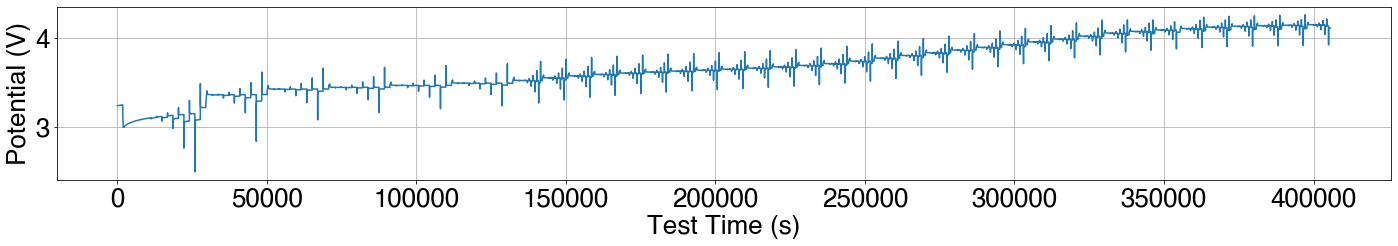

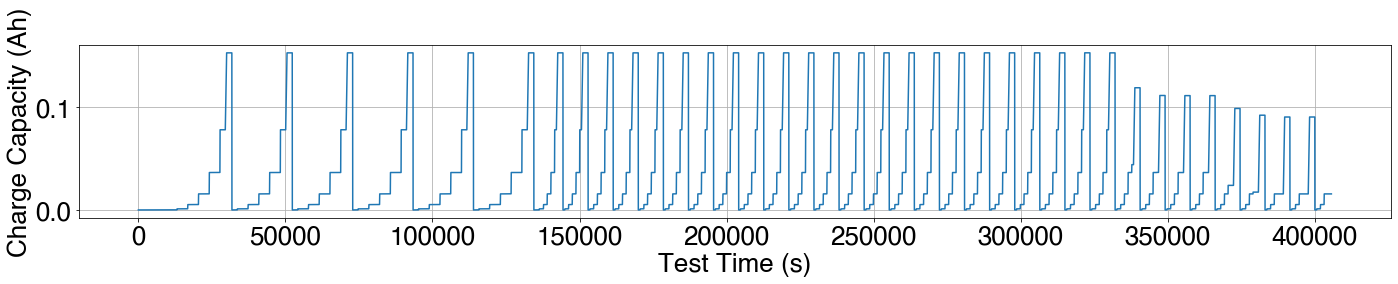

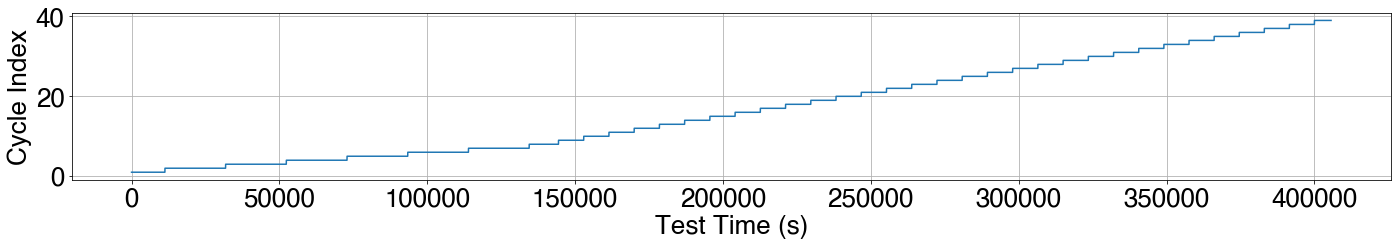

In [18]:
df_all = df_hppc_ext

plt.figure(figsize=(20,4))
plt.plot(df_all['Test Time (s)'], df_all['Potential (V)'])
plt.xlabel('Test Time (s)')
plt.ylabel('Potential (V)')

plt.figure(figsize=(20,4))
plt.plot(df_all['Test Time (s)'], df_all['Charge Capacity (Ah)'])
plt.xlabel('Test Time (s)')
plt.ylabel('Charge Capacity (Ah)')

plt.figure(figsize=(20,4))
plt.plot(df_all['Test Time (s)'], df_all['Cycle Number'])
plt.xlabel('Test Time (s)')
plt.ylabel('Cycle Index')


# Get charge capacity for each cycle index

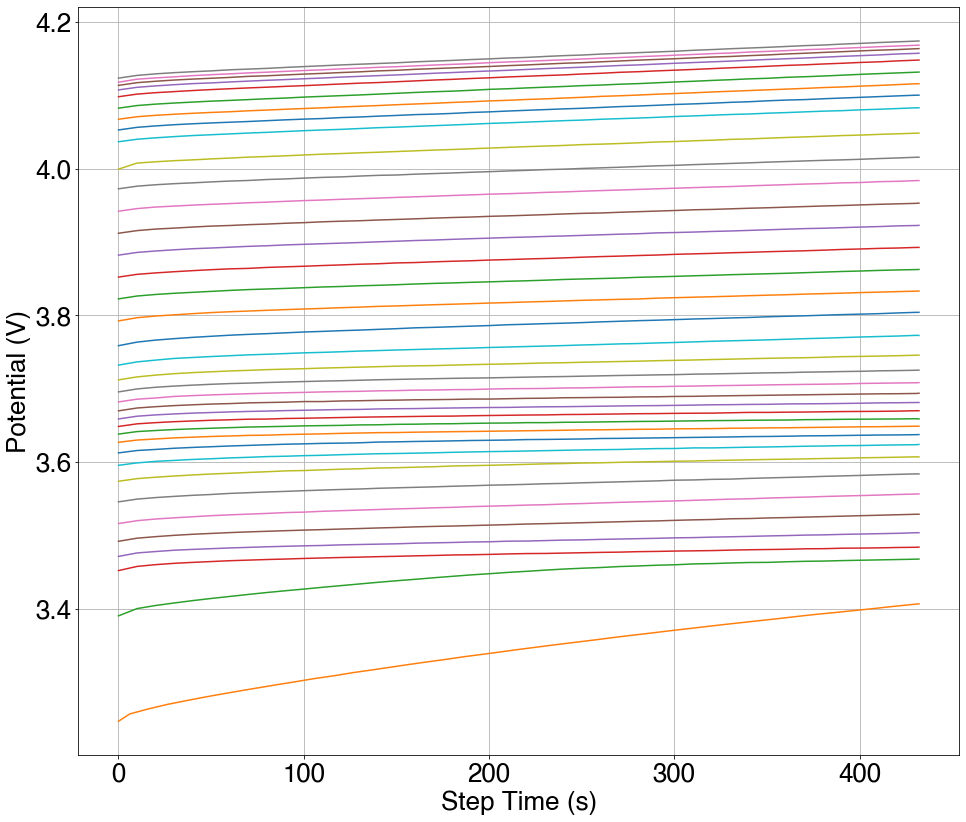

In [19]:
# Get cumulative charge capacities
step_index_soc_movement = 31

uniq_cyc_index = df_hppc_ext['Cycle Number'].unique()

charge_capacity_vec = []

plt.figure()
for cyc_index in uniq_cyc_index:

    curr_df = df_hppc_ext[df_hppc_ext['Cycle Number'] == cyc_index]
    curr_df_soc_movement = curr_df[curr_df['Step Index'] == step_index_soc_movement]

    capacity_moved_ah = np.max(curr_df_soc_movement['Charge Capacity (Ah)']) - \
                        np.min(curr_df_soc_movement['Charge Capacity (Ah)'])

    charge_capacity_vec.append(capacity_moved_ah)

    plt.plot(curr_df_soc_movement['Step Time (s)'],
             curr_df_soc_movement['Potential (V)'])

    plt.xlabel('Step Time (s)')
    plt.ylabel('Potential (V)')


# Note the relevant step indices

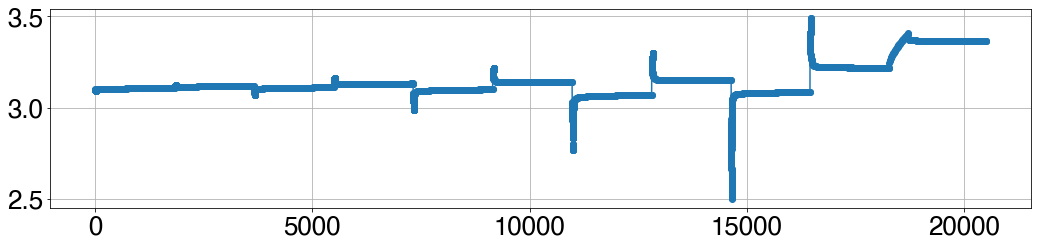

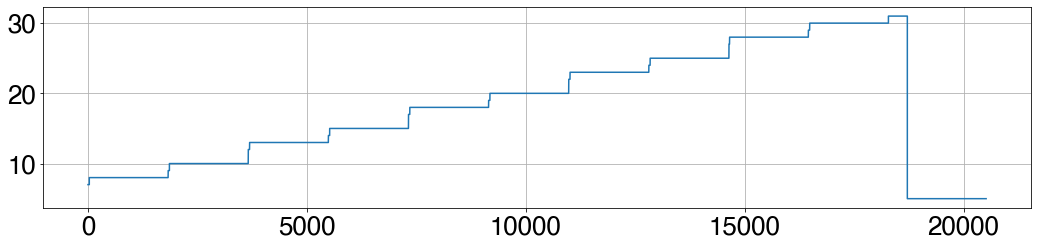

In [20]:
df = df_hppc_ext[df_hppc_ext['Cycle Number'] == 2]

x = df['Test Time (s)'] - np.min(df['Test Time (s)'])
y = df['Potential (V)']

plt.figure(figsize=(15,4))
plt.plot(x, y, 'o-')
plt.figure(figsize=(15,4))
plt.plot(x, df['Step Index'])

ax = plt.gca()
step_index_discharge_vec = [7, 12, 17, 22, 27]
c_rate_vec = ['C/20', 'C/5', 'C/2', '1C', 'C2']

# Make a test plot

...to get a sense at what's going on first

Text(0, 0.5, 'Voltage (V)')

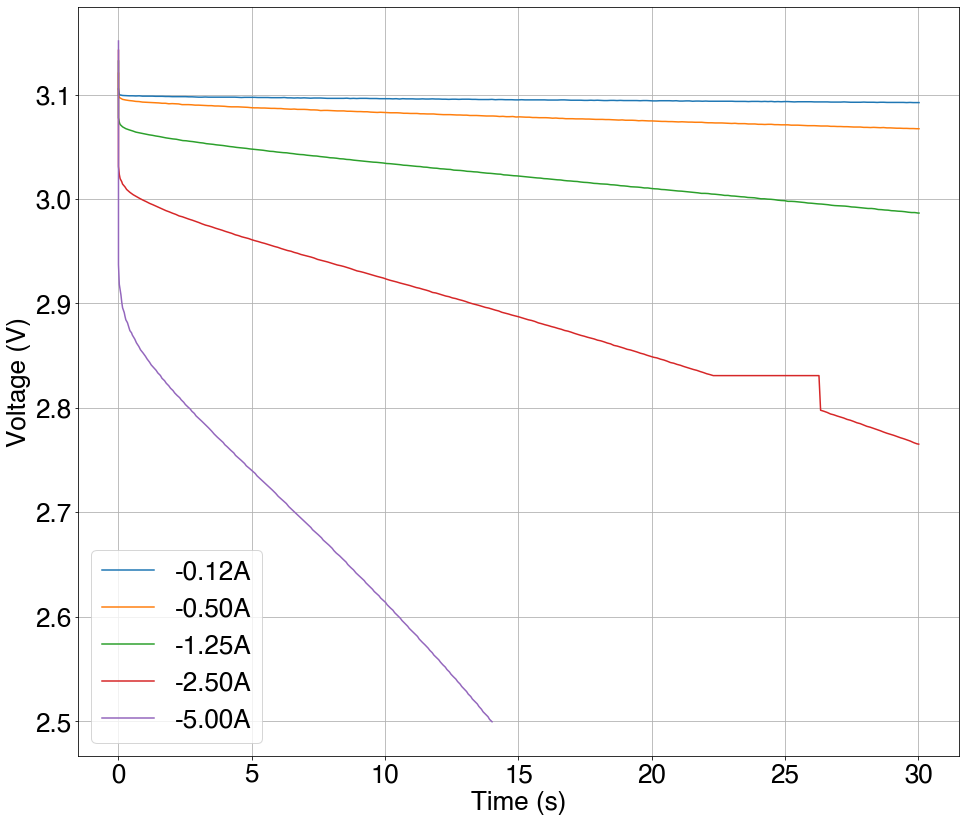

In [21]:
current_vec = []
rs_vec = []
r10s_t_vec = []
rs_t_vec = [] # store time points coresponding to Rs
r10s_vec = [] # store time points corresponding to 10s R

plt.figure()

for step_index in step_index_discharge_vec:

    this_df = df[df['Step Index'] == step_index]

    x = this_df['Step Time (s)'].values
    y = this_df['Potential (V)'].values

    current = np.median(this_df['Current (A)'].values)

    # Add the preceding time step for V0 (OCV)
    t = np.insert(x, 0, 0)
    V = np.insert(y, 0, df_hppc_ext['Potential (V)'].loc[this_df['Step Time (s)'].index[0]-1])

    idx = pd.Index(t).get_loc(10, method='nearest')

    current_vec.append(current)
    rs_vec.append( (V[0] - V[1]) / np.abs(current))
    rs_t_vec.append(t[1])
    r10s_vec.append( (V[0] - V[idx]) / np.abs(current))
    r10s_t_vec.append(t[idx])

    plt.plot(t, V, label=f'{current:.2f}A')

plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')


In [78]:
def calculate_resistances(df_hppc_ext : pd.DataFrame,
                          step_index_chg,
                          step_index_dch,
                          step_index_soc_movement,
                          rs_time_s,
                          rm_time_s,
                          rl_time_s,
                          show_debug_plot=True):

    """
    Organize the data using charge capacity (SOC) as the index.
    Filter by pulse type (step index)
    """

    uniq_cyc_index = df_hppc_ext['Cycle Number'].unique()

    if show_debug_plot:    
        gridspec = dict(wspace=0.25, width_ratios=[1, 1])

        fig, axs = plt.subplots(nrows=1, ncols=2,
                                gridspec_kw=gridspec,
                                figsize=(16, 16))

    rs_chg_vec = []
    rs_dch_vec = []
    rm_chg_vec = []
    rm_dch_vec = []
    rl_chg_vec = []
    rl_dch_vec = []
    charge_capacity_vec = []

    for cyc_index in uniq_cyc_index:

        if cyc_index == 1:
            continue

        curr_df = df_hppc_ext[df_hppc_ext['Cycle Number'] == cyc_index]
        prev_df = df_hppc_ext[df_hppc_ext['Cycle Number'] == cyc_index - 1]

        curr_df_soc_movement = prev_df[prev_df['Step Index'] == step_index_soc_movement]

        # Handle capacity vector
        if cyc_index == 2:
            capacity_moved_ah = 0
        else:
            capacity_moved_ah = np.max(curr_df_soc_movement['Charge Capacity (Ah)']) - \
                                np.min(curr_df_soc_movement['Charge Capacity (Ah)'])

        charge_capacity_vec.append(capacity_moved_ah)

        # Handle the charge pulses
        curr_chg = curr_df[curr_df['Step Index'] == step_index_chg]
        x = np.array(curr_chg['Step Time (s)'])
        y = np.array(curr_chg['Potential (V)'])

        if curr_chg.empty:
            rs_chg_vec.append(np.NaN)
            rm_chg_vec.append(np.NaN)
            rl_chg_vec.append(np.NaN)
            rs_dch_vec.append(np.NaN)
            rm_dch_vec.append(np.NaN)
            rl_dch_vec.append(np.NaN)
            continue
        
        t = np.insert(x, 0, 0)
        V = np.insert(y, 0, df_hppc_ext['Potential (V)'].loc[curr_chg['Step Time (s)'].index[0] - 1])
        # idx = pd.Index(t).get_loc(10, method='nearest')
        Vs = np.interp(rs_time_s, t, V)
        Vm = np.interp(rm_time_s, t, V)
        Vl = np.interp(rl_time_s, t, V)
        current = np.abs(np.median(curr_chg['Current (A)'].values))

        # Clean up incomplete pulses; do not parse if not complete
        if np.max(t) < rs_time_s:
            rs_chg_vec.append(np.NaN)
        else:
            rs_chg_vec.append( (Vs - V[0]) / np.abs(current))

        if np.max(t) < rm_time_s:
            rm_chg_vec.append(np.NaN)
        else:
            rm_chg_vec.append( (Vm - V[0]) / np.abs(current))
    
        if np.max(t) < rl_time_s:
            rl_chg_vec.append(np.NaN)
        else:
            rl_chg_vec.append( (Vl - V[0]) / np.abs(current))
        
        if show_debug_plot:
            axs[0].plot(t, V)
            axs[0].set_title('Charge Pulses')
        
        # Discharge pulses
        curr_dch = curr_df[curr_df['Step Index'] == step_index_dch]
        x = np.array(curr_dch['Step Time (s)'])
        y = np.array(curr_dch['Potential (V)'])
        t = np.insert(x, 0, 0)
        V = np.insert(y, 0, df_hppc_ext['Potential (V)'].loc[curr_dch['Step Time (s)'].index[0] - 1])
        Vs = np.interp(rs_time_s, t, V)
        Vm = np.interp(rm_time_s, t, V)
        Vl = np.interp(rl_time_s, t, V)
        # idx = pd.Index(t).get_loc(10, method='nearest')
        current = np.abs( np.median(curr_dch['Current (A)'].values) )

        # Clean up incomplete pulses; do not parse if not complete
        if np.max(t) < rs_time_s:
            rs_dch_vec.append(np.NaN)
        else:
            rs_dch_vec.append( (V[0] - Vs) / np.abs(current))

        if np.max(t) < rm_time_s:
            rm_dch_vec.append(np.NaN)
        else:
            rm_dch_vec.append( (V[0] - Vm) / np.abs(current))
    
        if np.max(t) < rl_time_s:
            rl_dch_vec.append(np.NaN)
        else:
            rl_dch_vec.append( (V[0] - Vl) / np.abs(current))

        if show_debug_plot:
            axs[1].plot(t, V)
            axs[1].set_title('Discharge Pulses')

        if show_debug_plot:
            for ax in axs:
                ax.set_xlim((0, 30))
                ax.set_title(f'{current:.2f}A Pulse')
                ax.set_xlabel('Time (s)')
                ax.set_ylabel('Voltage (V)')
                ax.grid(False)

    return (charge_capacity_vec, rs_chg_vec, rs_dch_vec,
                                 rm_chg_vec, rm_dch_vec,
                                 rl_chg_vec, rl_dch_vec)

In [68]:
def calculate_resistances_by_pulse_rate(df_hppc_ext : pd.DataFrame,
                                cyc_index,
                                rs_time_s,
                                rm_time_s,
                                rl_time_s,
                                ):
    """
    Group the results using pulse rate as the index.
    Filter by cycle index (SOC / charge capacity)
    """
    step_index_dch_vec = np.array([7, 12, 17, 22, 27])
    # step_index_dch_vec = np.array([12, 17, 22, 27])
    step_index_chg_vec = step_index_dch_vec + 2
    c_rate_vec = [0.05, 0.2, 0.5, 1, 2]
    # c_rate_vec = [0.2, 0.5, 1, 2]
    step_index_soc_movement = 31

    rs_chg_vec = []
    rs_dch_vec = []
    rm_chg_vec = []
    rm_dch_vec = []
    rl_chg_vec = []
    rl_dch_vec = []

    for step_index_dch, step_index_chg, c_rate in zip(step_index_dch_vec, 
                                                      step_index_chg_vec,
                                                      c_rate_vec):

        if cyc_index == 1:
            continue

        curr_df = df_hppc_ext[df_hppc_ext['Cycle Number'] == cyc_index]
        prev_df = df_hppc_ext[df_hppc_ext['Cycle Number'] == cyc_index - 1]

        curr_df_soc_movement = prev_df[prev_df['Step Index'] == step_index_soc_movement]

        # Handle capacity vector
        if cyc_index == 2:
            capacity_moved_ah = 0
        else:
            capacity_moved_ah = np.max(curr_df_soc_movement['Charge Capacity (Ah)']) - \
                                np.min(curr_df_soc_movement['Charge Capacity (Ah)'])

        charge_capacity_vec.append(capacity_moved_ah)

        # Handle the charge pulses
        curr_chg = curr_df[curr_df['Step Index'] == step_index_chg]
        x = np.array(curr_chg['Step Time (s)'])
        y = np.array(curr_chg['Potential (V)'])

        if curr_chg.empty:
            rs_chg_vec.append(np.NaN)
            rm_chg_vec.append(np.NaN)
            rl_chg_vec.append(np.NaN)
            rs_dch_vec.append(np.NaN)
            rm_dch_vec.append(np.NaN)
            rl_dch_vec.append(np.NaN)
            continue
        
        t = np.insert(x, 0, 0)
        V = np.insert(y, 0, df_hppc_ext['Potential (V)'].loc[curr_chg['Step Time (s)'].index[0] - 1])
        # idx = pd.Index(t).get_loc(10, method='nearest')
        Vs = np.interp(rs_time_s, t, V)
        Vm = np.interp(rm_time_s, t, V)
        Vl = np.interp(rl_time_s, t, V)
        current = np.abs(np.median(curr_chg['Current (A)'].values))

        # Clean up incomplete pulses; do not parse if not complete
        if np.max(t) < rs_time_s:
            rs_chg_vec.append(np.NaN)
        else:
            rs_chg_vec.append( (Vs - V[0]) / np.abs(current))

        if np.max(t) < rm_time_s:
            rm_chg_vec.append(np.NaN)
        else:
            rm_chg_vec.append( (Vm - V[0]) / np.abs(current))
    
        if np.max(t) < rl_time_s:
            rl_chg_vec.append(np.NaN)
        else:
            rl_chg_vec.append( (Vl - V[0]) / np.abs(current))
        
        # Discharge pulses
        curr_dch = curr_df[curr_df['Step Index'] == step_index_dch]
        x = np.array(curr_dch['Step Time (s)'])
        y = np.array(curr_dch['Potential (V)'])
        t = np.insert(x, 0, 0)
        V = np.insert(y, 0, df_hppc_ext['Potential (V)'].loc[curr_dch['Step Time (s)'].index[0] - 1])
        Vs = np.interp(rs_time_s, t, V)
        Vm = np.interp(rm_time_s, t, V)
        Vl = np.interp(rl_time_s, t, V)
        # idx = pd.Index(t).get_loc(10, method='nearest')
        current = np.abs(np.median(curr_dch['Current (A)'].values))

        # Clean up incomplete pulses; do not parse if not complete
        if np.max(t) < rs_time_s:
            rs_dch_vec.append(np.NaN)
        else:
            rs_dch_vec.append( (V[0] - Vs) / np.abs(current))

        if np.max(t) < rm_time_s:
            rm_dch_vec.append(np.NaN)
        else:
            rm_dch_vec.append( (V[0] - Vm) / np.abs(current))
    
        if np.max(t) < rl_time_s:
            rl_dch_vec.append(np.NaN)
        else:
            rl_dch_vec.append( (V[0] - Vl) / np.abs(current))

    return (c_rate_vec, rs_chg_vec, rs_dch_vec,
                        rm_chg_vec, rm_dch_vec,
                        rl_chg_vec, rl_dch_vec)

In [56]:
rm_time_s = 3    # Time to parse mid resistance
rl_time_s = 30    # Time to parse long resistance
rs_time_s = 0.05  # Time to parse series resistance

# Plot Resistance versus SOC

<ipython-input-100-2fbebb848700>:53: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.savefig(f'{output_path}/fig_kinetic_features_detailed_1.png', dpi=300, bbox_inches='tight')
/Users/aweng/opt/anaconda3/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/Users/aweng/opt/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


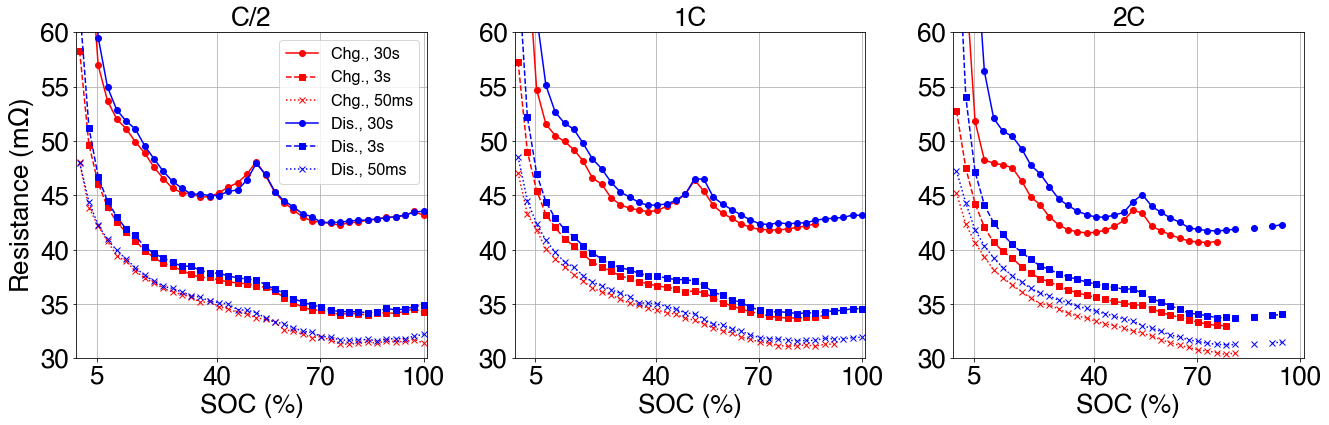

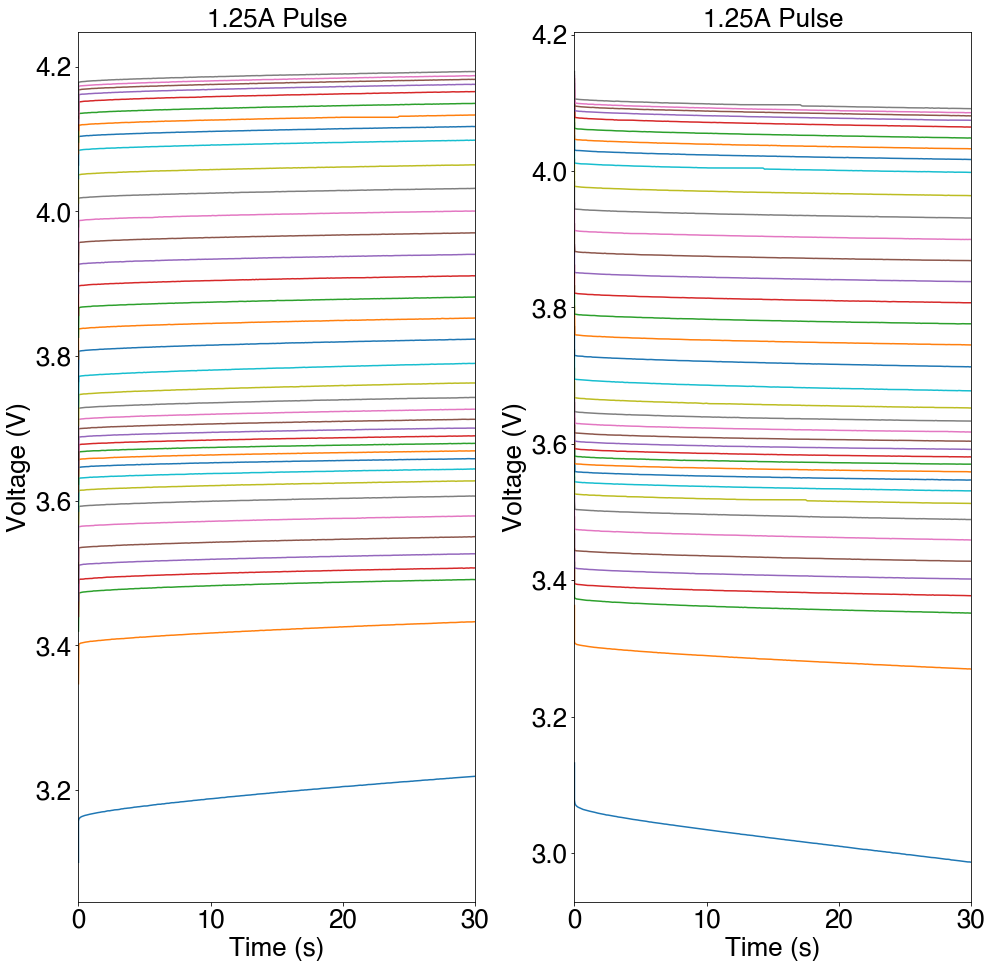

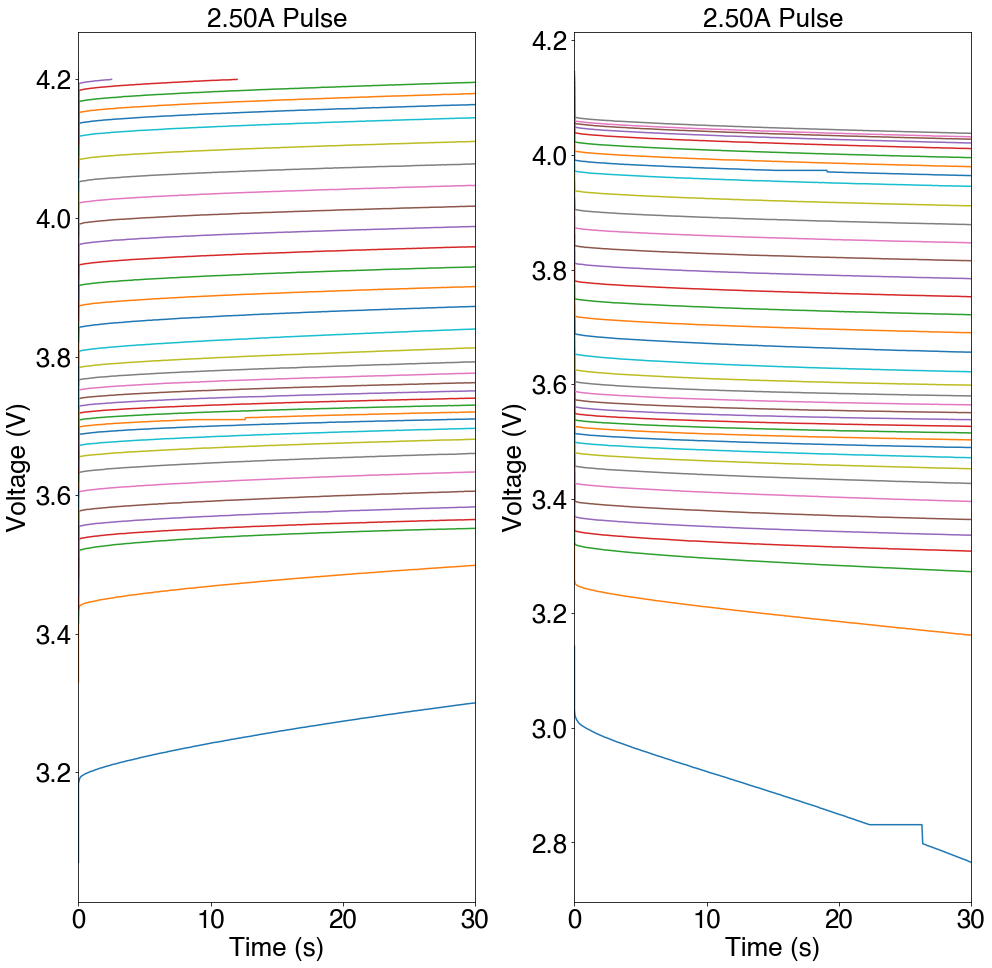

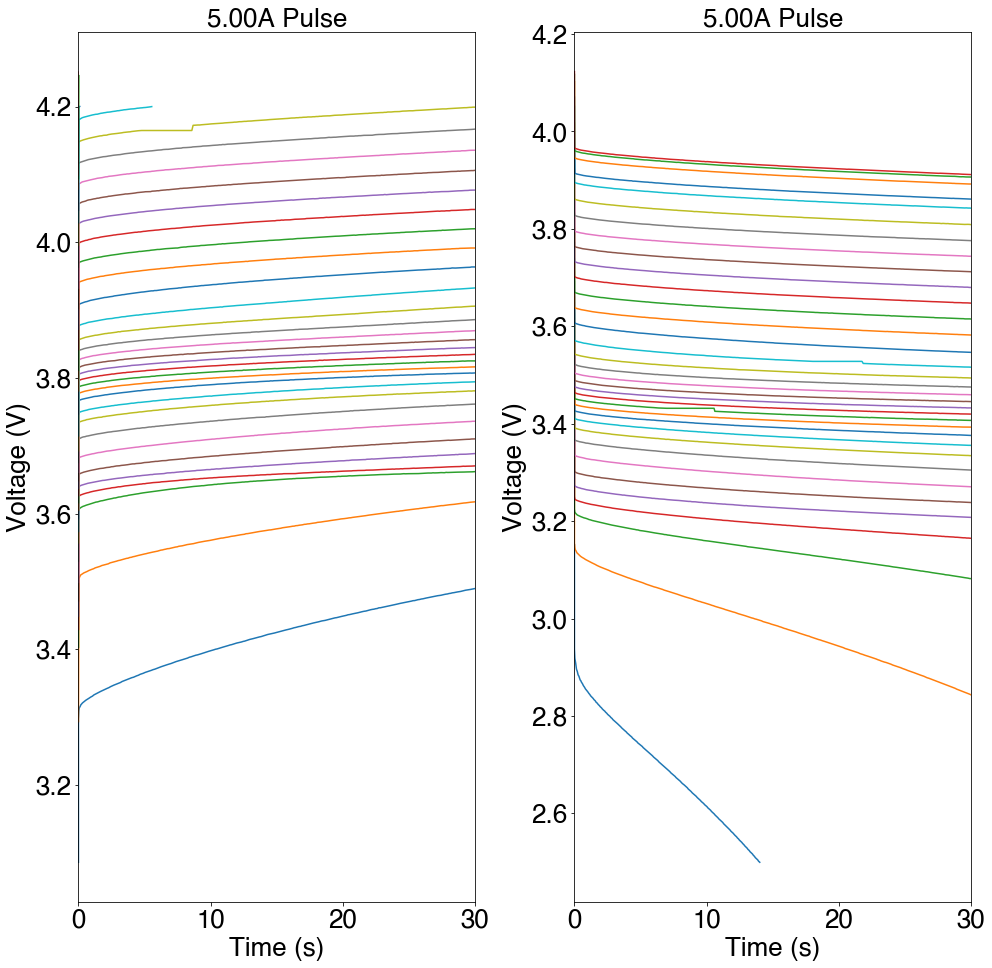

In [100]:
# Charge/discharge dependence
# step_index_discharge_vec = [7, 12, 17, 22, 27]
# label_vec = ['C/20', 'C/5', 'C/2', '1C', '2C']

step_index_discharge_vec = [17, 22, 27]
label_vec = ['C/2', '1C', '2C']
c_rate_vec = [0.5, 1, 2]

gridspec = dict(wspace=0.25, width_ratios=np.ones(len(label_vec)))

fig, axs = plt.subplots(nrows=1, ncols=len(label_vec),
                            gridspec_kw=gridspec,
                            figsize=(22, 6))

# step_index_discharge_vec = [7, 17, 27]
# label_vec = ['C/20 Pulses', 'C/2 Pulses', '2C Pulses']

for ax, step_index_dch, label, c_rate in zip(axs, step_index_discharge_vec, label_vec, c_rate_vec):

    step_index_chg = step_index_dch + 2
    step_index_soc_movement = 31

    (charge_capacity_vec, rs_chg_vec, rs_dch_vec,
                          rm_chg_vec, rm_dch_vec,
                          rl_chg_vec, rl_dch_vec) = calculate_resistances(
                                                        df_hppc_ext,
                                                        step_index_chg,
                                                        step_index_dch,
                                                        step_index_soc_movement,
                                                        rs_time_s,
                                                        rm_time_s,
                                                        rl_time_s
                        )
    soc = np.cumsum(charge_capacity_vec)
    soc = soc/np.max(soc) * 100
    ax.plot(soc, np.array(rl_chg_vec)*1e3, 'r-', marker='o', label=f'Chg., {rl_time_s}s')
    ax.plot(soc, np.array(rm_chg_vec)*1e3, 'r--', marker='s', label=f'Chg., {rm_time_s}s')
    ax.plot(soc, np.array(rs_chg_vec)*1e3, 'r:', marker='x', label=f'Chg., {rs_time_s*1e3:.0f}ms')
    ax.plot(soc, np.array(rl_dch_vec)*1e3, 'b-', marker='o', label=f'Dis., {rl_time_s}s')
    ax.plot(soc, np.array(rm_dch_vec)*1e3, 'b--', marker='s', label=f'Dis., {rm_time_s}s')
    ax.plot(soc, np.array(rs_dch_vec)*1e3, 'b:', marker='x', label=f'Dis., {rs_time_s*1e3:.0f}ms')
    ax.set_xlabel('SOC (%)')

    if ax == axs[0]:
        ax.set_ylabel('Resistance (m$\Omega$)')
        ax.legend(prop={'size' : 16})
    
    ax.set_xlim((-1, 101))
    ax.set_xticks([5, 40, 70, 100])
    ax.set_ylim((30, 60))
    ax.set_title(label)

fig.savefig(f'{output_path}/fig_kinetic_features_detailed_1.png', dpi=300, bbox_inches='tight')



<ipython-input-101-b136c035e9a5>:60: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.savefig(f'{output_path}/fig_kinetic_features_detailed_1_ratios.png', dpi=300, bbox_inches='tight')
/Users/aweng/opt/anaconda3/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/Users/aweng/opt/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


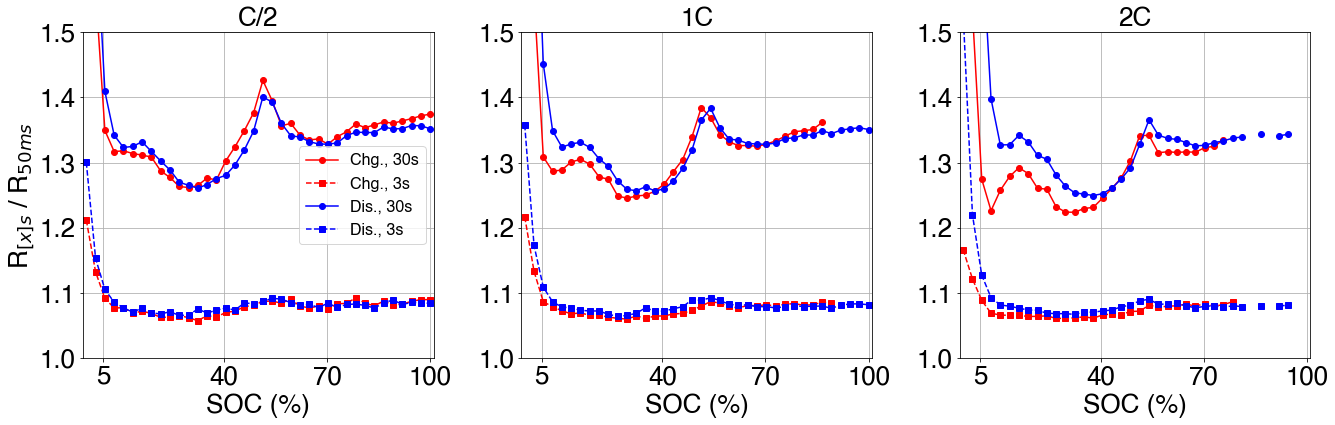

In [101]:
# Charge/discharge dependence
# step_index_discharge_vec = [7, 12, 17, 22, 27]
# label_vec = ['C/20', 'C/5', 'C/2', '1C', '2C']

step_index_discharge_vec = [17, 22, 27]
label_vec = ['C/2', '1C', '2C']

gridspec = dict(wspace=0.25, width_ratios=np.ones(len(label_vec)))

fig, axs = plt.subplots(nrows=1, ncols=len(label_vec),
                            gridspec_kw=gridspec,
                            figsize=(22, 6))

# step_index_discharge_vec = [7, 17, 27]
# label_vec = ['C/20 Pulses', 'C/2 Pulses', '2C Pulses']

for ax, step_index_dch, label in zip(axs, step_index_discharge_vec, label_vec):

    step_index_chg = step_index_dch + 2
    step_index_soc_movement = 31

    (charge_capacity_vec, rs_chg_vec, rs_dch_vec,
                          rm_chg_vec, rm_dch_vec,
                          rl_chg_vec, rl_dch_vec) = calculate_resistances(
                                                        df_hppc_ext,
                                                        step_index_chg,
                                                        step_index_dch,
                                                        step_index_soc_movement,
                                                        rs_time_s,
                                                        rm_time_s,
                                                        rl_time_s,
                                                        show_debug_plot=False
                                                    )
    soc = np.cumsum(charge_capacity_vec)
    soc = soc/np.max(soc) * 100

    rl_chg = np.array(rl_chg_vec)
    rm_chg = np.array(rm_chg_vec)
    rs_chg = np.array(rs_chg_vec)

    rl_dch = np.array(rl_dch_vec)
    rm_dch = np.array(rm_dch_vec)
    rs_dch = np.array(rs_dch_vec)

    ax.plot(soc, rl_chg/rs_chg, 'r-', marker='o', label=f'Chg., {rl_time_s}s')
    ax.plot(soc, rm_chg/rs_chg, 'r--', marker='s', label=f'Chg., {rm_time_s}s')
    ax.plot(soc, rl_dch/rs_dch, 'b-', marker='o', label=f'Dis., {rl_time_s}s')
    ax.plot(soc, rm_dch/rs_dch, 'b--', marker='s', label=f'Dis., {rm_time_s}s')
    ax.set_xlabel('SOC (%)')

    if ax == axs[0]:
        ax.set_ylabel(f'R$_{{[x]s}}$ / R$_{{{rs_time_s*1e3:.0f}ms}}$')
        ax.legend(prop={'size' : 16})
    
    ax.set_xlim((-1, 101))
    ax.set_xticks([5, 40, 70, 100])
    ax.set_ylim((1, 1.5))
    ax.set_title(label)

fig.savefig(f'{output_path}/fig_kinetic_features_detailed_1_ratios.png', dpi=300, bbox_inches='tight')

# SOC to Cycle Index Mapping

In [26]:
pd.DataFrame([soc, df_all['Cycle Number'].unique()]).transpose()

,0,1
0,0.000000,1.0
1,2.702731,2.0
2,5.405376,3.0
3,8.108137,4.0
4,10.810861,5.0
5,13.513606,6.0
6,16.216105,7.0
7,18.918929,8.0
8,21.621507,9.0
9,24.324035,10.0


<ipython-input-79-4bfb80417622>:41: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.savefig(f'{output_path}/fig_kinetic_features_detailed_2.png', dpi=300, bbox_inches='tight')
/Users/aweng/opt/anaconda3/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/Users/aweng/opt/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


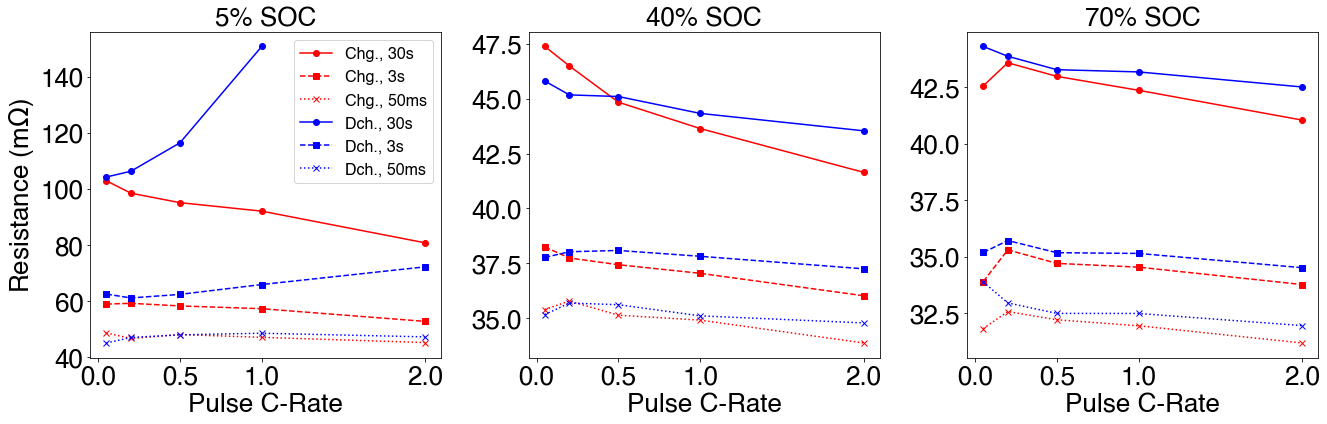

In [79]:
target_cyc_index_vec = [2, 15, 26]
label_vec = ['5% SOC', '40% SOC', '70% SOC']


# Charge/discharge dependence
gridspec = dict(wspace=0.25, width_ratios=[1, 1, 1])

fig, axs = plt.subplots(nrows=1, ncols=3,
                            gridspec_kw=gridspec,
                            figsize=(22, 6))


for ax, cyc_index, label in zip(axs, target_cyc_index_vec, label_vec):

    (c_rate_vec, rs_chg_vec, rs_dch_vec,
                          rm_chg_vec, rm_dch_vec,
                          rl_chg_vec, rl_dch_vec) = calculate_resistances_by_pulse_rate(
                                                        df_hppc_ext,
                                                        cyc_index,
                                                        rs_time_s,
                                                        rm_time_s,
                                                        rl_time_s)
    c_rate_vec = np.array(c_rate_vec)                       
    ax.plot(c_rate_vec, np.array(rl_chg_vec)*1e3, 'r-',  marker='o', label=f'Chg., {rl_time_s}s')
    ax.plot(c_rate_vec, np.array(rm_chg_vec)*1e3, 'r--', marker='s', label=f'Chg., {rm_time_s}s')
    ax.plot(c_rate_vec, np.array(rs_chg_vec)*1e3, 'r:',  marker='x', label=f'Chg., {rs_time_s*1e3:.0f}ms')
    ax.plot(c_rate_vec, np.array(rl_dch_vec)*1e3, 'b-',  marker='o', label=f'Dch., {rl_time_s}s')
    ax.plot(c_rate_vec, np.array(rm_dch_vec)*1e3, 'b--', marker='s', label=f'Dch., {rm_time_s}s')
    ax.plot(c_rate_vec, np.array(rs_dch_vec)*1e3, 'b:',  marker='x', label=f'Dch., {rs_time_s*1e3:.0f}ms')

    ax.set_xlabel('Pulse C-Rate')
    if ax == axs[0]:
        ax.set_ylabel('Resistance (m$\Omega$)')
        ax.legend(prop={'size' : 16}, loc='upper right')
    ax.set_title(label)

for ax in axs:
    ax.set_xticks([0, 0.5, 1, 2])
    ax.grid(False)

fig.savefig(f'{output_path}/fig_kinetic_features_detailed_2.png', dpi=300, bbox_inches='tight')